# Initializing

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from typing import Iterable, Optional, Union
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.validation import check_is_fitted
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import (train_test_split, 
                                    RandomizedSearchCV, 
                                    StratifiedKFold)
from sklearn.metrics import (classification_report, 
                            f1_score, 
                            confusion_matrix)


In [4]:
class FraudDetector(BaseEstimator, ClassifierMixin):

    def __init__(self, random_state: int = 39, n_jobs: Optional[int] = None):
        self.random_state = random_state
        self.n_jobs = n_jobs
        self._model_ = RandomForestClassifier(
            n_estimators=500,
            n_jobs=self.n_jobs,
            random_state=self.random_state,
        )
    
    def fit(
        self,
        X: Union[np.ndarray, pd.DataFrame],
        y: Union[np.ndarray, pd.Series],
        sample_weight: Optional[Iterable[float]] = None,
    ):
        """
        Fit the model using a training X and y.

        Parameters:
        -----------
        X (np.ndarray | pd.DataFrame): The training data
        y (np.ndarray | pd.Sereis): The corresponding targets
        sample_weight (iterable): Sample class weights (default=None)
        """

        X_balanced, y_balanced = self._handle_imbalance(X, y) # you can modify the parameters here if needed
        if sample_weight is None:
            self._model_.fit(X_balanced, y_balanced)
        else:
            self._model_.fit(X_balanced, y_balanced, sample_weight=sample_weight)
        return self

    def predict(self, X: Union[np.ndarray, pd.DataFrame]) -> np.ndarray:
        """Predict the outcome from data X."""
        check_is_fitted(self, "_model_")
        return self._model_.predict(X)

    def fit_predict(
        self, X: Union[np.ndarray, pd.DataFrame], y: Union[np.ndarray, pd.Series]
    ) -> np.ndarray:
        """
        Fit the model using a training X and y, and predict the outcome using
        X. Note that this would give the predicted labels during training.
        """
        
        return self.fit(X, y).predict(X)

    #### START MODIFY THIS METHOD
    #### Ensure docstrings and missing type annotations are found in this
    #### method.
    #### You can modify the parameters here, but ensure that these are reflected
    #### within the fit method
    def _handle_imbalance(
        self, X: Union[np.ndarray, pd.DataFrame], y: Union[np.ndarray, pd.Series]
        ) -> tuple[np.ndarray, np.ndarray]:
        """
        Handle class imbalance using SMOTE.
    
        Parameters
        ----------
        X : np.ndarray | pd.DataFrame
            Feature matrix.
        y : np.ndarray | pd.Series
            Target labels.
    
        Returns
        -------
        tuple[np.ndarray, np.ndarray]
            Resampled feature matrix and target labels.
        """
        
        if self.use_smote:
            smote = SMOTE(
                random_state=self.random_state,
                k_neighbors=self.n_neighbors,
                sampling_strategy=self.sampling_strategy
            )
            X_resampled, y_resampled = smote.fit_resample(X, y)
            return X_resampled, y_resampled
    
        return X, y


    #### END MODIFY THIS METHOD

    ### CREATE HELPER METHODS IF NEEDED FOR  _handle_imbalance METHOD
    ### NOTE THAT THE METHODS YOU CREATE SHOULD START WITH AN UNDERSCORE (_)


In [5]:
df = pd.read_csv('historical.csv')
df.head()

,tid,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,outcome
0,49b18cea-beb8-413d-b268-a0ec12a4147c,1.423808,-0.377568,0.242070,-0.697073,-0.763104,-0.731960,-0.367360,-0.278617,-0.996840,...,-0.469381,-0.810630,0.034175,-0.063592,0.252775,0.975686,-0.047713,0.008093,10.00,0
1,0d1de000-6756-4441-8133-e0ed75b72979,0.386691,1.932803,-1.958157,1.795148,0.597989,-1.752021,0.567382,0.225227,-0.614899,...,-0.037188,0.066752,0.232243,0.269168,-0.566513,-0.403250,0.151074,-0.044239,3.99,0
2,dc548f8c-ecd2-4fee-8a80-f2de7e2c7bd6,-0.822247,1.349695,-2.533342,-1.510371,2.429420,3.097419,-0.337696,1.778629,-0.306968,...,-0.280728,-0.954416,0.226719,0.589009,-0.325611,0.173346,0.110327,-0.006745,14.55,0
3,f105abf5-0c4c-4e79-9a8a-59de254e58dc,-0.679009,0.452323,1.256676,-1.163474,-0.871992,-0.413326,-0.319045,0.414021,-1.479641,...,0.171611,0.365879,-0.164711,0.366073,0.089739,-0.314979,-0.185542,-0.032110,10.00,0
4,164a2881-40c6-43ba-b53e-cd1e5a9e8cee,1.174152,-0.493073,-0.136508,-1.375827,-0.506841,-0.760343,0.066490,-0.174785,1.165490,...,-0.061790,-0.016600,-0.226672,0.107551,0.738778,-0.010159,-0.008166,0.006128,68.54,0


In [6]:
df = df.drop(columns = ['tid'])

# EDA

## Univariate

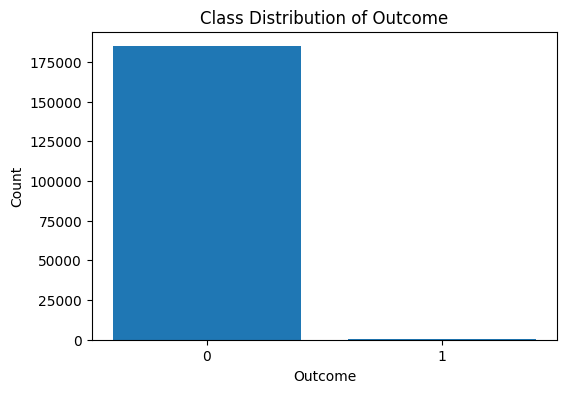

In [7]:
# Count values
class_counts = df["outcome"].value_counts().sort_index()

# Plot
plt.figure(figsize=(6,4))
plt.bar(class_counts.index.astype(str), class_counts.values)
plt.title("Class Distribution of Outcome")
plt.xlabel("Outcome")
plt.ylabel("Count")


plt.show()


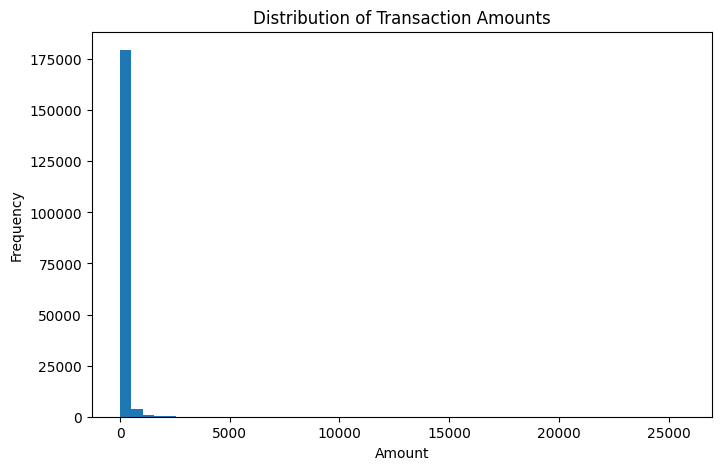

In [8]:
plt.figure(figsize=(8,5))
plt.hist(df["Amount"], bins=50)
plt.title("Distribution of Transaction Amounts")
plt.xlabel("Amount")
plt.ylabel("Frequency")
plt.show()


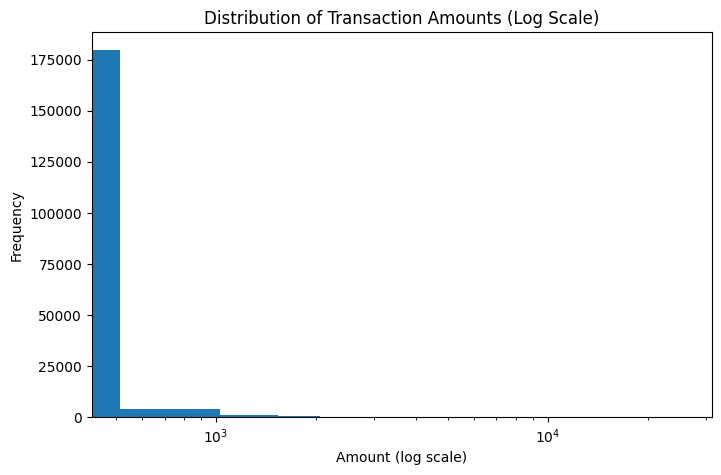

In [9]:
plt.figure(figsize=(8,5))
plt.hist(df["Amount"], bins=50)
plt.xscale("log")
plt.title("Distribution of Transaction Amounts (Log Scale)")
plt.xlabel("Amount (log scale)")
plt.ylabel("Frequency")
plt.show()


## Bivariate

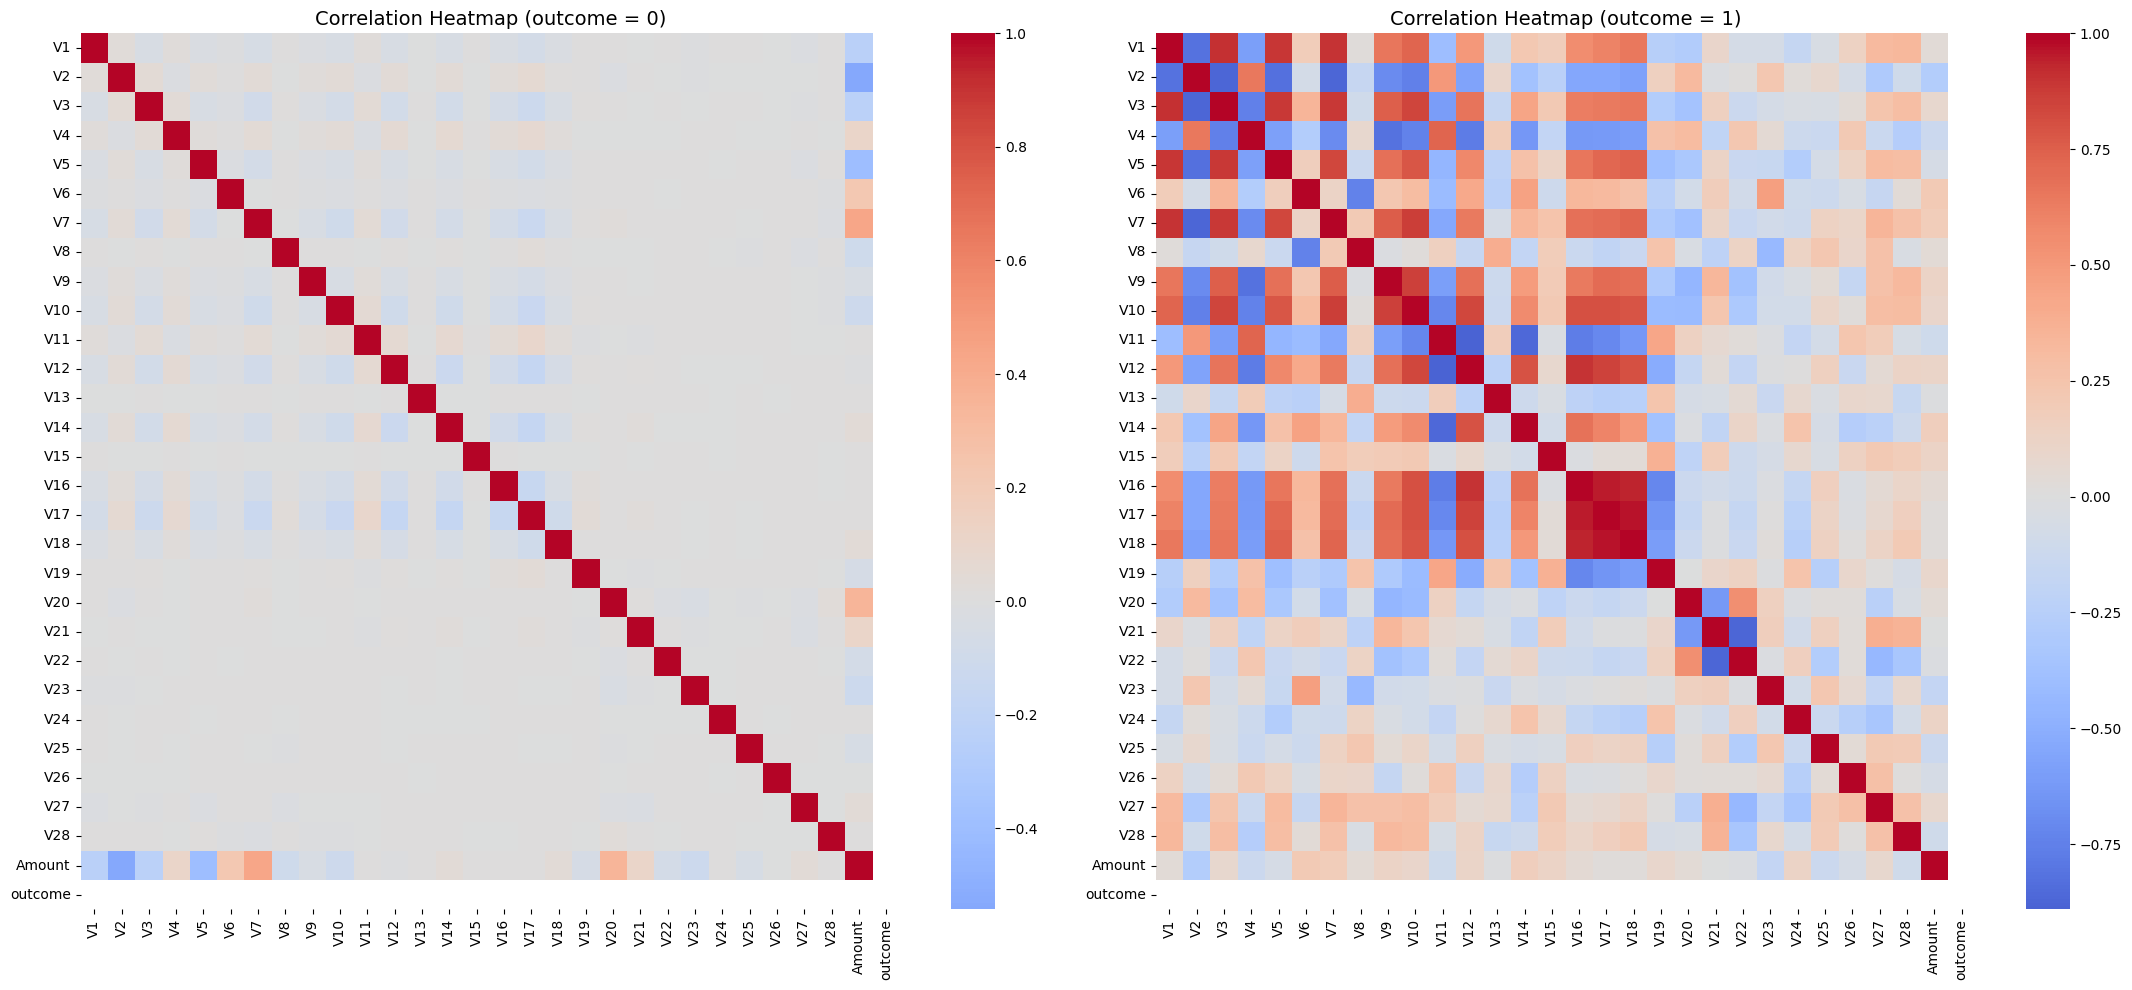

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Split datasets
df_0 = df[df["outcome"] == 0]
df_1 = df[df["outcome"] == 1]

# Compute correlation matrices
corr_0 = df_0.corr()
corr_1 = df_1.corr()

# Plot side-by-side heatmaps
fig, axes = plt.subplots(1, 2, figsize=(22, 10))

sns.heatmap(
    corr_0,
    cmap="coolwarm",
    center=0,
    annot=False,
    cbar=True,
    ax=axes[0]
)
axes[0].set_title("Correlation Heatmap (outcome = 0)", fontsize=14)

sns.heatmap(
    corr_1,
    cmap="coolwarm",
    center=0,
    annot=False,
    cbar=True,
    ax=axes[1]
)
axes[1].set_title("Correlation Heatmap (outcome = 1)", fontsize=14)

plt.tight_layout()
plt.show()

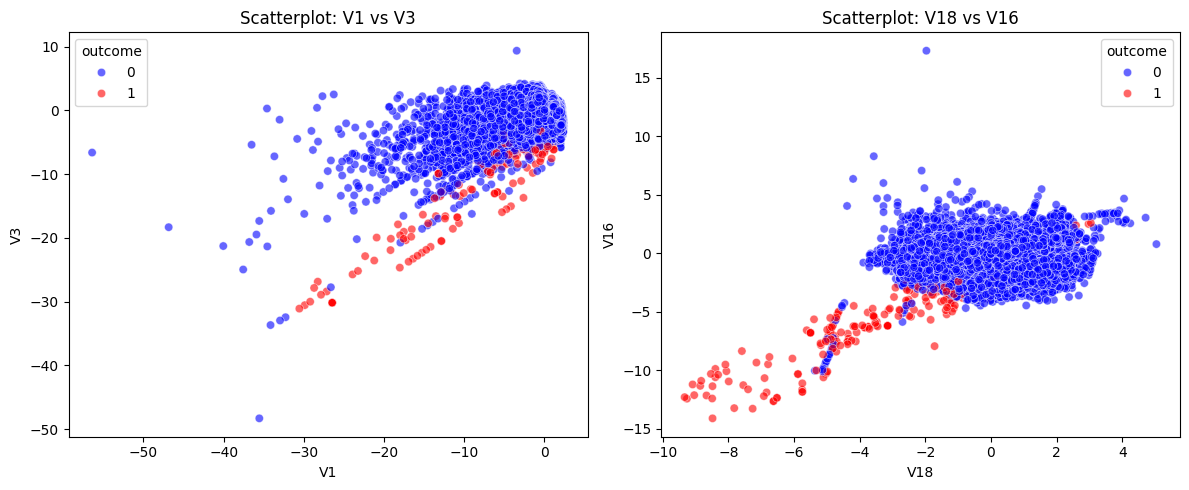

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,5))

# V1 vs V3
plt.subplot(1,2,1)
sns.scatterplot(
    data=df,
    x="V1", y="V3",
    hue="outcome",
    alpha=0.6,
    palette={0: "blue", 1: "red"}
)
plt.title("Scatterplot: V1 vs V3")

# V18 vs V16
plt.subplot(1,2,2)
sns.scatterplot(
    data=df,
    x="V18", y="V16",
    hue="outcome",
    alpha=0.6,
    palette={0: "blue", 1: "red"}
)
plt.title("Scatterplot: V18 vs V16")

plt.tight_layout()
plt.show()

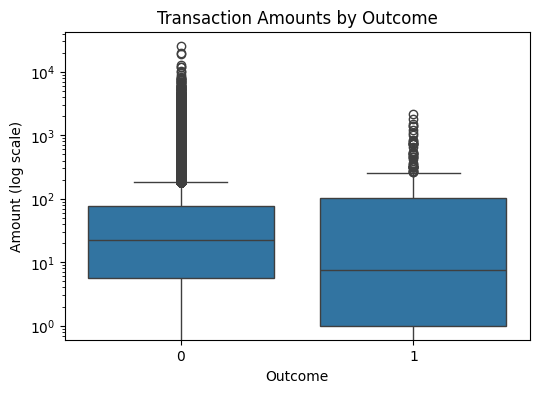

In [12]:
plt.figure(figsize=(6,4))
sns.boxplot(
    x="outcome",
    y="Amount",
    data=df
)
plt.yscale("log")  # handle skewness
plt.title("Transaction Amounts by Outcome")
plt.xlabel("Outcome")
plt.ylabel("Amount (log scale)")
plt.show()


# Data Preprocessing

In [13]:
# Count of nulls per column
df.isnull().sum()

V1         0
V2         0
V3         0
V4         0
V5         0
V6         0
V7         0
V8         0
V9         0
V10        0
V11        0
V12        0
V13        0
V14        0
V15        0
V16        0
V17        0
V18        0
V19        0
V20        0
V21        0
V22        0
V23        0
V24        0
V25        0
V26        0
V27        0
V28        0
Amount     0
outcome    0
dtype: int64

In [14]:
df.duplicated().sum()

np.int64(4670)

In [15]:
df_clean = df.drop_duplicates()

In [16]:
seed = 31
C = 1.0
penalty = 'l1'

smote_model = Pipeline(
   [
        ("scaler", StandardScaler()),
        ("clf", FraudDetector(random_state=39, n_jobs=-1))
    ]
)

In [17]:
df

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,outcome
0,1.423808,-0.377568,0.242070,-0.697073,-0.763104,-0.731960,-0.367360,-0.278617,-0.996840,0.635636,...,-0.469381,-0.810630,0.034175,-0.063592,0.252775,0.975686,-0.047713,0.008093,10.00,0
1,0.386691,1.932803,-1.958157,1.795148,0.597989,-1.752021,0.567382,0.225227,-0.614899,-1.470780,...,-0.037188,0.066752,0.232243,0.269168,-0.566513,-0.403250,0.151074,-0.044239,3.99,0
2,-0.822247,1.349695,-2.533342,-1.510371,2.429420,3.097419,-0.337696,1.778629,-0.306968,-0.947894,...,-0.280728,-0.954416,0.226719,0.589009,-0.325611,0.173346,0.110327,-0.006745,14.55,0
3,-0.679009,0.452323,1.256676,-1.163474,-0.871992,-0.413326,-0.319045,0.414021,-1.479641,0.080683,...,0.171611,0.365879,-0.164711,0.366073,0.089739,-0.314979,-0.185542,-0.032110,10.00,0
4,1.174152,-0.493073,-0.136508,-1.375827,-0.506841,-0.760343,0.066490,-0.174785,1.165490,-1.054033,...,-0.061790,-0.016600,-0.226672,0.107551,0.738778,-0.010159,-0.008166,0.006128,68.54,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185119,1.160806,0.156483,0.591316,0.502971,-0.336953,-0.315516,-0.116835,0.068581,-0.228519,0.059694,...,-0.165291,-0.481752,0.179518,0.218196,0.086627,0.094319,-0.016192,0.007358,1.29,0
185120,1.560825,-1.325706,-0.770189,-2.497505,0.693174,3.454604,-1.834426,0.856034,-1.736648,1.487323,...,-0.115227,-0.057266,-0.033700,0.997058,0.503315,-0.087907,0.055294,0.020042,8.80,0
185121,1.886785,-0.106240,-0.078499,1.210325,-0.492892,-0.224197,-0.483004,0.079694,0.501983,0.341594,...,-0.046154,-0.059968,0.358256,-0.043922,-0.434514,-0.946105,0.058215,-0.031296,11.00,0
185122,-0.784597,-0.871087,1.255600,-1.950215,0.474308,0.165334,0.213067,-0.011141,-0.850115,0.067066,...,0.073609,-0.166800,0.146472,-1.387013,-0.144569,-0.502711,-0.112214,-0.098017,125.30,0


# Baseline

We use 3-way split

In [18]:
target = df["outcome"]

X, y = df.iloc[:, :-1], df.iloc[:, -1]

# Test set (Hold-out)
X_Train, X_test, y_Train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0, stratify=target
)

# Train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_Train, y_Train, test_size=0.2, random_state=0, stratify=y_Train
)

print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")

X_train shape: (118479, 29)
X_val shape: (29620, 29)


In [ ]:
def RF_Class(x_val,x_train,x_test,y_val, y_train,y_test):

    lr = RandomForestClassifier(n_estimators=500,
                                random_state=36).fit(x_train, y_train)

    trainscore = lr.score(x_train, y_train)  # record training set accuracy
    valscore = lr.score(x_val, y_val)  #validation accuracy 
    testscore = lr.score(x_test, y_test) #test accuracy

    # Predictions on test set
    y_pred = lr.predict(x_test)

    # Classification report and confusion matrix
    class_report = classification_report(y_test, y_pred, output_dict=False)  # string format
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Print classification report
    print("Classification Report:")
    print(class_report)

    # Plot confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
                xticklabels=lr.classes_, yticklabels=lr.classes_)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    return class_report, conf_matrix


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     36961
           1       0.98      0.66      0.79        64

    accuracy                           1.00     37025
   macro avg       0.99      0.83      0.89     37025
weighted avg       1.00      1.00      1.00     37025



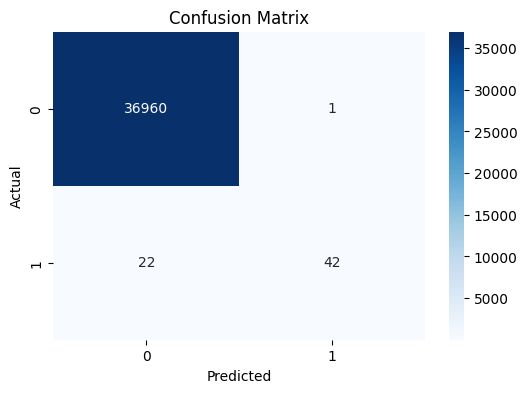

('              precision    recall  f1-score   support\n\n           0       1.00      1.00      1.00     36961\n           1       0.98      0.66      0.79        64\n\n    accuracy                           1.00     37025\n   macro avg       0.99      0.83      0.89     37025\nweighted avg       1.00      1.00      1.00     37025\n',
 array([[36960,     1],
        [   22,    42]]))

In [ ]:

RF_Class(X_val, X_train,X_test, y_val, y_train,y_test)


Additional Notes 
- Please follow how prof did it in his ntbk
- kindly include as well how it looked like before and after smote using scatterplot 
- include hyperparameter tuning for k (untuned vs tuned metrics as well)
- include additional metric for fraud capture rate 
                               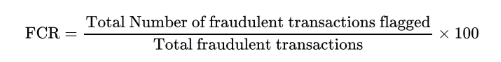

# Handle Class Imbalance

# Modeling

# Using Test.csv

Please use the test.csv file and include the output based on our model and export it in a csv file